In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.set_printoptions(linewidth=160)
np.random.seed(42)

In [2]:
POPULATION_PER_AGE = 1000
MAX_AGE = 50
NUM_YEARS = 50


def deterministic_catalytic_model(
    lambda_by_year: np.ndarray,
) -> np.ndarray:
    """

    """
    # susceptible and Infected by age group and year
    SI_out = np.zeros((NUM_YEARS+1, MAX_AGE+1, 3))

    # Initial first year
    SI_out[0, :, 0] = POPULATION_PER_AGE
    # 100 Births every year
    SI_out[:, 0, 0] = POPULATION_PER_AGE

    lambda_by_year_and_age = np.repeat(lambda_by_year.reshape(-1, 1), MAX_AGE, axis=1)

    for y_num in range(NUM_YEARS):
        for a_num in range(MAX_AGE):
            curr_susceptible = SI_out[y_num, a_num, 0]
            curr_infection = SI_out[y_num, a_num, 1]

            curr_lamb = min(lambda_by_year_and_age[y_num, a_num], 1)

            created_infections = curr_susceptible * curr_lamb

            new_susceptible = curr_susceptible - created_infections
            new_infection = curr_infection + created_infections

            SI_out[y_num + 1, a_num + 1, 0] = new_susceptible
            SI_out[y_num + 1, a_num + 1, 1] = new_infection
            SI_out[y_num, a_num, 2] = created_infections

    return SI_out


def sum_squared_error(
    ground_truth: np.ndarray,
    best_guess: np.ndarray,
) -> float:
    return ((ground_truth - best_guess)**2).sum()


def objective_function(
    lambda_by_year: np.ndarray,
    infections_by_year_gt: np.ndarray,
) -> float:
    SI_out = deterministic_catalytic_model(lambda_by_year)
    infections_by_year_guess = SI_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)
    return sum_squared_error(infections_by_year_gt, infections_by_year_guess)

In [3]:
lambda_by_year = np.random.uniform(0.05, 0.15, NUM_YEARS)
SI_out = deterministic_catalytic_model(lambda_by_year=lambda_by_year)

infections_by_year_gt = SI_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

In [4]:
initial_guess = np.random.uniform(0.05, 0.15, NUM_YEARS)
SI_out_guess = deterministic_catalytic_model(lambda_by_year=initial_guess)
infections_by_year_guess = SI_out_guess[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

In [5]:
results_nm = minimize(
    objective_function,
    x0=initial_guess,
    args=(infections_by_year_gt,),
    method="Nelder-Mead",
    options={"maxiter": 10000},
)

results_bfgs = minimize(
    objective_function,
    x0=np.ones(NUM_YEARS) * 0.1,
    args=(infections_by_year_gt,),
    method="L-BFGS-B",
    bounds=[(0.01, 0.25)] * NUM_YEARS,
    options={"maxiter": 100},
)


In [6]:
nm_lambda_si_out = deterministic_catalytic_model(results_nm.x)
bfgs_lambda_si_out = deterministic_catalytic_model(results_bfgs.x)
infections_by_year_nm_res = nm_lambda_si_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)
infections_by_year_bfgs_res = bfgs_lambda_si_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

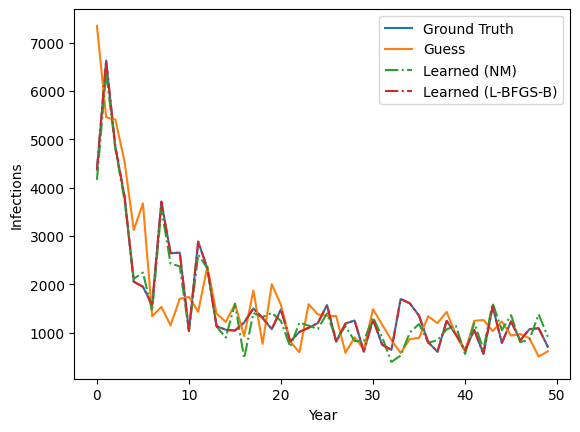

In [7]:
plt.plot(infections_by_year_gt, label="Ground Truth")
plt.plot(infections_by_year_guess, label="Guess")
plt.plot(infections_by_year_nm_res, '-.', label="Learned (NM)")
plt.plot(infections_by_year_bfgs_res, '-.', label="Learned (L-BFGS-B)")
plt.ylabel("Infections")
plt.xlabel("Year")
plt.legend()
plt.show()